In [1]:
import numpy as np
import pandas as pd
import os
import torch 
from torch import nn, optim 
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torch.utils.data
import matplotlib.pyplot as plt
import time
import itertools
import glob 
from PIL import Image
import csv 
import cv2
import random
# import torch.nn.functional as F
from torchvision.transforms import functional as F

In [ ]:
# !pip install --upgrade albumentations
# import albumentations as A

In [2]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


## To Do: 

### Test Model on new things (Apple logo, different fruits etc.)
### Try doing solution 1 and then if not working then solution 2 (For Lable changing you can do it manually with code on the dataframe or something of that nature). 
### Use Metrics (from papers or something else that is popular) for object detection and integrate a test function. Can try to (Look at coco losses in pytorch code)
### Find Third party augmentations and make shift in code.

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
###### Label Data and put them in the csv file (might need to do this before training). 


##### Add to the spreadsheet by getting info about agencies or research that is to help people who suffer from blindness.


## Links 
* Model: 
https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

* For Albumentations look at open source github
For Cropping 
https://github.com/albumentations-team/albumentations/blob/master/albumentations/augmentations/crops/transforms.py
https://github.com/albumentations-team/albumentations/blob/ae50578a46e5981eccaafee311a3ee0b4b7992b2/albumentations/augmentations/crops/functional.py#L22


# How to solve bad spots problem 
First run the fruit detector -> bouding box over every fruit. 
Then I will crop the image along the bouding box. 
Then run the cropped image through another bounding box detector and get object detection of bad_spots.

# Another solution 
Find Models that can work with neural network object detection crowding. 

#Another Solution
So I can remove the bad spot label and then have
["Apple", "Bad Apple", "Strawberry", "Bad Strawberry"] etc.

#Even another solution 
["Apple", "Specific Apple badspot"]
Like current model except differtiating against other black spots.

In [3]:
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/Fruit Defects Dataset HalfWay.zip", 'r') as zip_ref:
    zip_ref.extractall()

In [4]:
#For one strawberry batch please drop watermark rows
strawberry_csv_batch_3 = pd.read_csv("/content/Fruit Defects Dataset /Train/FreshStrawberries/Fresh StrawBerry Batch 3 Labeled/FreshStrawberryBatch3Labels.csv", header = None)
strawberry_csv_batch_2 = pd.read_csv("/content/Fruit Defects Dataset /Train/FreshStrawberries/Fresh StrawBerry Batch 2 Labeled/FreshStrawberriesBatch2Labels.csv", header = None)
strawberry_csv_batch_1 = pd.read_csv("/content/Fruit Defects Dataset /Train/FreshStrawberries/Fresh StrawBerry Batch 1 Labeled/Strawberrybatch1.csv", header = None)
rottenApple_csv_batch_1 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenApples/RottenAppleBatch1Labeled/RottenAppleBatch1Labels.csv", header = None)
rottenApple_csv_batch_2 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenApples/RottenAppleBatch2Labeled/RottenApplesBatch2Labels.csv", header = None)
rottenApple_csv_batch_3 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenApples/RottenAppleBatch3Labaled/RottenApplesBatch3Labels.csv", header = None)
rottenStrawberry_csv_batch_1 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenStrawberries/Batch1RottenStrawBerryLabels/RottenStrawberriesBatch1Labels.csv", header = None)
rottenStrawberry_csv_batch_2 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenStrawberries/Batch2RottenStrawBerryLabels/RottenStrawBerryBatch2.csv", header = None)
rottenStrawberry_csv_batch_3 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenStrawberries/Batch3RottenStrawberrylabel/rottenStrawberryBtch3labels.csv", header = None)

strawberry_csv_batch_3.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
strawberry_csv_batch_2.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
strawberry_csv_batch_1.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenApple_csv_batch_1.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenApple_csv_batch_2.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenApple_csv_batch_3.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenStrawberry_csv_batch_1.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenStrawberry_csv_batch_2.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenStrawberry_csv_batch_3.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]

#Drop some watermark data for Fresh StrawBerry Batch 1 Labeled images [59, 9, 93]

# strawberry_csv_batch_1 = strawberry_csv_batch_1[Image_id not in ["FreshStrawberries59.jpeg, FreshStrawberries9.jpeg, FreshStrawberries93.jpeg"]]
strawberry_csv_batch_1.drop(strawberry_csv_batch_1[strawberry_csv_batch_1["Image_id"] == "FreshStrawberries59.jpeg"].index, inplace = True)
strawberry_csv_batch_1.drop(strawberry_csv_batch_1[strawberry_csv_batch_1["Image_id"] == "FreshStrawberries9.jpeg"].index, inplace = True)
strawberry_csv_batch_1.drop(strawberry_csv_batch_1[strawberry_csv_batch_1["Image_id"] == "FreshStrawberries93.jpeg"].index, inplace = True)
strawberry_csv_batch_1 = strawberry_csv_batch_1.reset_index(drop=True)

#Stack all the csv files together. 
list_of_all_dataframes = [strawberry_csv_batch_1, strawberry_csv_batch_2, strawberry_csv_batch_3, rottenApple_csv_batch_1, 
                          rottenApple_csv_batch_2, rottenApple_csv_batch_3, rottenStrawberry_csv_batch_1, rottenStrawberry_csv_batch_2, 
                          rottenStrawberry_csv_batch_3]
fruit_df = pd.concat(list_of_all_dataframes, ignore_index = True)

total_row_sum_check = 0 
for dataframe in list_of_all_dataframes:
  total_row_sum_check += dataframe.shape[0]
print("Checked total rows from all the dataframes combined: {}".format(total_row_sum_check))
assert total_row_sum_check == fruit_df.shape[0]
print("DataFrame shape: {}".format(fruit_df.shape))
print("Unique Fruit Labels {}".format(fruit_df["Fruit"].unique()))
print("Number of Unique Images {}".format(len(fruit_df["Image_id"].unique())))
  


Checked total rows from all the dataframes combined: 844
DataFrame shape: (844, 8)
Unique Fruit Labels ['Strawberry' 'Apples' 'Bad_Spots']
Number of Unique Images 246


In [5]:
#Post Processing 
fruit_df = fruit_df[fruit_df["Image_id"] != "FreshStrawberries15.jpeg"]

In [6]:
bounding_box_dict = dict()
labels_dict = dict()
classes = ["Bad_Spots", "Strawberry", "Apples"]

for row_index in range(len(fruit_df)): 
  current_image_file = fruit_df.iloc[row_index]["Image_id"]
  if current_image_file not in bounding_box_dict:
    bounding_box_dict[current_image_file] = list()
    labels_dict[current_image_file] = list()
  bounding_box_dict[current_image_file].append(fruit_df.iloc[row_index, 1:5].to_list())
  labels_dict[current_image_file].append(classes.index(fruit_df.iloc[row_index, 0]))

print(len(bounding_box_dict))
print(len(labels_dict))

245
245


## Class function + util functions

In [7]:
def ffile_path(image_id, full_image_file_paths):
  for image_path in full_image_file_paths:
    if image_id in image_path:
      return image_path

def find_area_bb(bb_coord):
  bb_coord = bb_coord.numpy()
  area_of_each_bb = list()
  for pair_of_coord in bb_coord:
    area_of_each_bb.append(
        (pair_of_coord[2] - pair_of_coord[0]) * (pair_of_coord[3] - pair_of_coord[1])
    )
  return torch.tensor(area_of_each_bb, dtype=torch.int32)

def convert_min_max(bb_coord):
  for pair_of_coord in bb_coord:
    pair_of_coord[2], pair_of_coord[3] = (pair_of_coord[0] + pair_of_coord[-2]), (pair_of_coord[1] + pair_of_coord[-1])
  return bb_coord

class FruitDetectDataset(object):
  def __init__(self, id_labels, id_bounding_boxes, transforms):

    assert len(id_labels) == len(id_bounding_boxes)
    assert sorted(id_labels.keys()) == sorted(id_bounding_boxes.keys())
    self.imgs_key = sorted(id_labels.keys())
    self.id_labels = id_labels
    self.id_bounding_boxes = id_bounding_boxes
    self.full_image_file_paths = glob.glob("/content/Fruit Defects Dataset /Train/*/*/*.jpeg")

    self.transforms = transforms

  def __getitem__(self, idx):

    img_path = ffile_path(self.imgs_key[idx], self.full_image_file_paths)    
    img = Image.open(img_path).convert("RGB") ## No Image path sometimes
    boxes = convert_min_max(torch.as_tensor(self.id_bounding_boxes[self.imgs_key[idx]], dtype=torch.float32))
    
    labels = torch.as_tensor(self.id_labels[self.imgs_key[idx]], dtype=torch.int64)
    image_id = torch.tensor([idx])
    area = find_area_bb(boxes)

    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["image_id"] = image_id
    target["area"] = area
    
    #Query about transforms for labels of images
    if self.transforms: 
      img, target = self.transforms(img, target)
    
    
    return img, target

  def __len__(self):
    return len(self.imgs_key)

In [8]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target


# class RandomHorizontalFlip(object):
#     def __init__(self, prob):
#         self.prob = prob

#     def __call__(self, image, target):
#         if random.random() < self.prob:
#             _,  width = image.shape[-2:]
#             image = image.flip(-1)
#             #Can change entire list by altering internal lists
#             #Property only of lists of lists etc.
#             for bb_coord in target["boxes"]:
#               bb_coord[0], bb_coord[2] = (width - bb_coord[0]), (width - bb_coord[2])
#               #Reorder into min max format
#               if bb_coord[0] > bb_coord[2]:
#                 new_pair = list(bb_coord)
#                 new_pair[0], new_pair[2] = new_pair[2], new_pair[0]
#                 bb_coord = torch.as_tensor(new_pair)
            
            

#         return image, target


class ToTensor(object):
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target

In [9]:
#Using this stack overflow (https://stackoverflow.com/questions/65279115/how-to-use-collate-fn-with-dataloaders)
#(Suppose for example, you want to create batches of a list of varying dimension tensors. The below code pads sequences with 0 until the maximum sequence size of the batch,)
#Collate_fn is a function that is used to process your batches before you pass it to dataloader. In my case since I have different sized images I need a way to stack batches b/c torch.stack won't work.
#So I use zip which can accept tensors of different lengths and make them stacked with the size of the lowest length list given. Therefore stacking all the images in a batch 
#Successfully unlike torch.stack and doing that processing to every batch makes collate_fn vital since I have different image sizes.

def collate_fn(batch):
  return tuple([list(a) for a in zip(*batch)])
    # return tuple(zip(*batch))

np.random.seed(42)
torch.manual_seed(42)
batch_size = 20

def get_transform(train):
    transform = []
    transform.append(ToTensor())
    if train:
        transform.append(RandomHorizontalFlip(0.5))
    return Compose(transform)

train_dataset = FruitDetectDataset(labels_dict, bounding_box_dict, get_transform(train = False))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True, collate_fn= collate_fn)

In [10]:
COLORS = [(255, 0, 0) for i in range(len(classes))]
COLORS[0] = (0, 0, 255)

def draw_boxes(boxes, labels, image):
    # read the image with OpenCV
    image = image.permute(1, 2, 0).numpy()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    for i, box in enumerate(boxes):
        color = COLORS[labels[i]]
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, 2
        )
        cv2.putText(image, classes[labels[i]], (int(box[0]), int(box[1]-5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2, 
                    lineType=cv2.LINE_AA)
    return image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

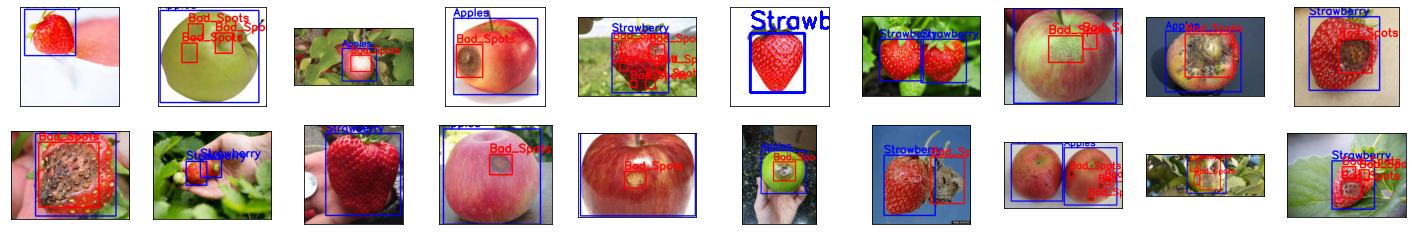

In [11]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    image = cv2.cvtColor(draw_boxes(labels[idx]["boxes"], labels[idx]["labels"], images[idx]), cv2.COLOR_BGR2RGB)
    plt.imshow(image)

In [12]:
def train(net, epochs, train_loader, lr):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    #Check which parameters can calulate gradients. 
    params = [p for p in net.parameters() if p.requires_grad]
    optimizer = optim.Adam(params, lr = lr)

    net.to(device)
    print("Device: {}".format(device))
    print("Optimizer: {}".format(optimizer))
    
    start_time = time.time()
    
    for epoch in range(epochs):
        net.train()
        
        train_loss = 0
        
        for batch_idx, (images, targets) in enumerate(train_loader):

            images = [image.to(device) for image in images]
            targets = [{key: value.to(device) for key, value in t.items()} for t in targets]

            optimizer.zero_grad()
            
            loss_dict = net(images, targets)
            losses = sum(loss for loss in loss_dict.values())
                
            losses.backward()
            optimizer.step()

            train_loss +=  losses.item()
        print("Epoch {} | Train_loss {:0.2f}".format(epoch, train_loss))
    
    print("Time for Total Training {:0.2f}".format(time.time() - start_time))
    return net


## This link shows the problem https://github.com/pytorch/vision/issues/2740
The answer from @oke-aditya is correct. You are probably passing to the model bounding boxes in the format [xmin, ymin, width, height], while Faster R-CNN expects boxes to be in [xmin, ymin, xmax, ymax] format.

Changing this should fix the issue.

We have btw recently added box conversion utilities to torchvision (thanks to @oke-aditya ), they can be found in

Look at box convert or doing it locally also works.

### https://github.com/pytorch/vision/blob/a98e17e50146529cdfadb590ba063e6bbee71de2/torchvision/ops/boxes.py#L137-L156




In [14]:
import torchvision
backbone = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=False)
backbone.roi_heads.box_predictor.cls_score.out_features = 3
backbone.roi_heads.box_predictor.bbox_pred.out_features = 12

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


In [35]:
another_one = train(backbone, 20, train_loader, 0.001)

Device: cuda
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
Epoch 0 | Train_loss 13.72
Epoch 1 | Train_loss 6.01
Epoch 2 | Train_loss 6.38
Epoch 3 | Train_loss 5.92
Epoch 4 | Train_loss 5.80
Epoch 5 | Train_loss 5.90
Epoch 6 | Train_loss 5.63
Epoch 7 | Train_loss 4.90
Epoch 8 | Train_loss 4.41
Epoch 9 | Train_loss 4.74
Epoch 10 | Train_loss 4.23
Epoch 11 | Train_loss 4.17
Epoch 12 | Train_loss 3.79
Epoch 13 | Train_loss 4.03
Epoch 14 | Train_loss 4.40
Epoch 15 | Train_loss 4.06
Epoch 16 | Train_loss 3.65
Epoch 17 | Train_loss 3.40
Epoch 18 | Train_loss 3.21
Epoch 19 | Train_loss 3.21
Time for Total Training 159.88


In [38]:
def infer_image(image_file_path, trained_model, distance_thresh, show_image = True):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print("Current device: {}".format(device))

  torch_image = F.to_tensor(Image.open(image_file_path).convert("RGB")).unsqueeze(0).to(device)
  trained_model.to(device)
  trained_model.eval()
  print("Image Size: {}".format(torch_image.size()))

  results = trained_model(torch_image)
  
  for ii, score in enumerate(results[0]["scores"]):
    if score < distance_thresh:
      low_index_start = ii
      break

  for key in results[0]:
    results[0][key] = results[0][key][:low_index_start]

  if show_image:
    if device == torch.device("cuda"):
      torch_image = torch_image.cpu() 
    plt.imshow(cv2.cvtColor(draw_boxes(results[0]["boxes"], results[0]["labels"], torch_image.squeeze()), cv2.COLOR_BGR2RGB))
  
  return results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Current device: cuda
Image Size: torch.Size([1, 3, 340, 511])
[{'boxes': tensor([[220.4989, 134.7736, 325.5309, 297.9868]], device='cuda:0',
       grad_fn=<SliceBackward>), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.7255], device='cuda:0', grad_fn=<SliceBackward>)}]


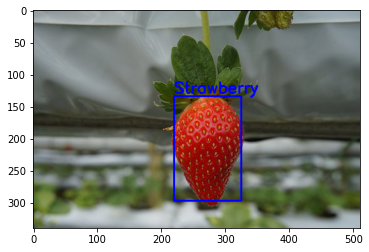

In [46]:
first_results = infer_image("/content/new_one_straw.jpg", 
            another_one, 0.6)
print(first_results)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Current device: cuda
Image Size: torch.Size([1, 3, 800, 779])
[{'boxes': tensor([[220.5646, 183.8161, 553.3694, 406.4978]], device='cuda:0',
       grad_fn=<SliceBackward>), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.6708], device='cuda:0', grad_fn=<SliceBackward>)}]


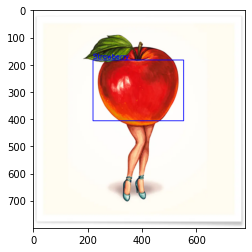

In [48]:
third_results = infer_image("/content/hard_one.webp", 
            another_one, 0.6)
print(third_results)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Current device: cuda
Image Size: torch.Size([1, 3, 1200, 1200])
[{'boxes': tensor([[457.6199, 270.1039, 857.5180, 647.7678]], device='cuda:0',
       grad_fn=<SliceBackward>), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.6497], device='cuda:0', grad_fn=<SliceBackward>)}]


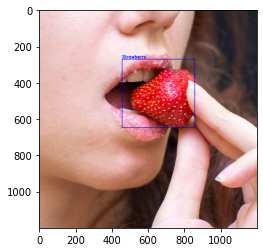

In [47]:
second_results = infer_image("/content/test_image.jpg", 
            another_one, 0.6)
print(second_results)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Current device: cuda
Image Size: torch.Size([1, 3, 275, 183])
[{'boxes': tensor([[ 21.2647, 139.2814,  83.7956, 197.2815],
        [ 83.6448, 177.8798, 153.8207, 244.2725],
        [ 78.5771, 103.6482, 175.5262, 169.8727],
        [ 16.5514,  80.1204,  82.5546, 133.9214],
        [ 78.5232,  98.3190, 165.9364, 172.1909]], device='cuda:0',
       grad_fn=<SliceBackward>), 'labels': tensor([1, 1, 1, 1, 2], device='cuda:0'), 'scores': tensor([0.7041, 0.6805, 0.6759, 0.6595, 0.6059], device='cuda:0',
       grad_fn=<SliceBackward>)}]


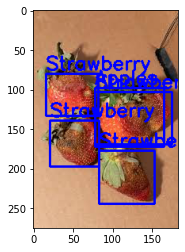

In [50]:
n_results = infer_image("/content/Fruit Defects Dataset /Train/RottenStrawberries/Batch3RottenStrawberrylabel/RottenStrawberries106.jpeg", 
            another_one, 0.6)
print(n_results)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Current device: cuda
Image Size: torch.Size([1, 3, 168, 300])
[{'boxes': tensor([[144.0670,  26.6101, 245.9770, 124.2361],
        [ 61.3974,  48.2567, 148.0112, 121.1279],
        [ 47.0246,  34.4680, 276.6150, 127.3922]], device='cuda:0',
       grad_fn=<StackBackward>), 'labels': tensor([2, 2, 2], device='cuda:0'), 'scores': tensor([0.9924, 0.9676, 0.7793], device='cuda:0', grad_fn=<IndexBackward>)}]


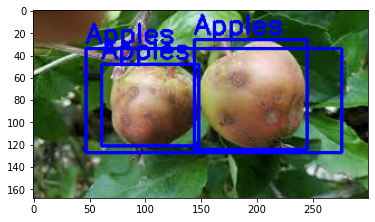

In [ ]:
third_results = infer_image("/content/Fruit Defects Dataset /Train/RottenApples/RottenAppleBatch2Labeled/RottenApples104.jpeg", 
            another_one)
print(third_results)

In [ ]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

#Got this code from Pytorch
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
backbone.out_channels = 1280
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=["0"],
                                                output_size=7,
                                                sampling_ratio=2)

model = FasterRCNN(backbone,
                   num_classes= 3,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

In [ ]:
big_model_trained = train(model, 5, train_loader, 0.001)

Device: cuda
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
Train_loss 75.02
Train_loss 51.36
Train_loss 46.14
Train_loss 41.43
Train_loss 41.80
Time for Total Training 239.89


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Current device: cuda
Image Size: torch.Size([1, 3, 168, 300])
[{'boxes': tensor([[ 69.1474,  64.2751, 148.4620, 114.3899],
        [147.6721,  34.3109, 244.3341, 125.7101],
        [156.2975,  67.2296, 241.7707, 115.6172],
        [ 61.2172,  42.1268, 160.4226, 123.7934],
        [ 55.4112,  20.6403, 148.2688, 147.1536],
        [140.1581,  12.8032, 242.8702, 137.1573],
        [ 72.9599,  55.8225, 120.6715, 124.0824],
        [155.7516,  35.8434, 240.7453,  81.8439],
        [ 77.4504,  55.6837, 131.3480, 120.5511],
        [151.3064,  67.0160, 242.2128, 114.8050],
        [149.8626,  37.6520, 240.1790,  81.6439],
        [ 60.8129,  57.2972, 156.9139, 103.6539],
        [122.2360,  13.8358, 258.2636, 147.7872],
        [ 29.6507,  19.7816, 169.5312, 146.5081],
        [182.2252,  44.1733, 233.2106, 123.7305],
        [178.9846,  42.9360, 232.7902, 122.1008]], device='cuda:0',
       grad_fn=<StackBackward>), 'labels': tensor([1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2], device='c

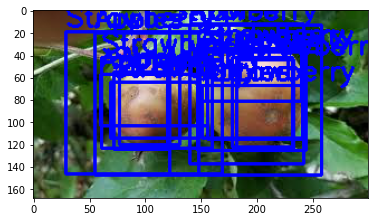

In [ ]:
fourth_results = infer_image("/content/Fruit Defects Dataset /Train/RottenApples/RottenAppleBatch2Labeled/RottenApples104.jpeg", 
            big_model_trained)
print(fourth_results)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Current device: cuda
Image Size: torch.Size([1, 3, 174, 290])
[{'boxes': tensor([[114.4126,  48.2813, 250.1729, 155.0493],
        [102.2642,  31.0849, 261.7426, 164.4938],
        [117.0008,  73.7661, 186.9274, 146.0458],
        [  0.0000,  21.1495,  97.8701, 138.1350],
        [178.6789,  52.1009, 247.4369, 139.9945],
        [  0.0000,  18.8515,  97.3643, 138.6392],
        [112.2559,  76.6795, 183.6730, 148.2949],
        [175.4311,  52.3117, 247.0582, 140.5845]], device='cuda:0',
       grad_fn=<StackBackward>), 'labels': tensor([1, 2, 1, 2, 1, 1, 2, 2], device='cuda:0'), 'scores': tensor([0.5465, 0.3288, 0.3139, 0.2520, 0.1927, 0.1442, 0.1310, 0.0508],
       device='cuda:0', grad_fn=<IndexBackward>)}]


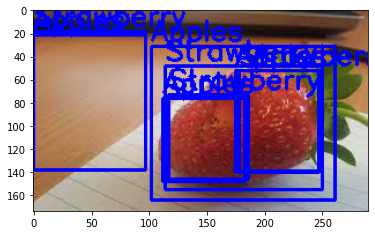

In [ ]:
fifth_results = infer_image("/content/Fruit Defects Dataset /Train/RottenStrawberries/Batch1RottenStrawBerryLabels/RottenStrawberries114.jpeg", 
            big_model_trained)
print(fifth_results)